# Projeto 1 - Ciência dos Dados

Nome: Letícia Coêlho Barbosa

Nome: Matheus Silva Melo de Oliveira

## Contextualização

------------------------------------------------------------

O produto escolhido para a classificação foi a tão falada e renomada série do Universo de Star Wars,<em><b>The Mandalorian</b></em> atualmente vinculado, a Disney e transmitido no serviço de assinatura Disney+.

<br>

A classificação foi realizada com intuito de analisar caso internautas ou possíveis consumidores da série comentam sobre esta na rede social Twitter. O critério utilizado para relevância foi caso o usuário fizesse algum comentário que remetia algum laço de intensidade em relação à série, positivo ou não, como elogiando algum capítulo, sentindo saudade da série ou criticando algum aspecto relevante à obra. Tweets que falavam apenas de aspectos tangentes à esse certame, como elogios ou comentários a atores da obra, listagens no qual à série se enquadra e vagas menções sobre a série foram consideradas como irrelevantes nessa classificação.

<em>Alguns dos principais tópicos contidos nos tweets</em>
- Elogiando episódio final da segunda temporada
- Elogiando o personagem principal da obra, Mandaloriano ou o personagem em CGI, apeliadado de "Baby Yoda"
- Elogios à série, com advérbios que remetem falta da série, que está em hiato, ou elogios à história
- Comentários alheios a atores e atrizes da obra, como Pedro Pascal
- Comparações com outras obras, principalmente Wandavision, do mesmo serviço de streaming Disney+

<br>

<center><img src="mandalorian_assets/mandalorian.gif" width=500 style="float: center; margin: 0px 0px 10px 10px"></center>
<center><b>Cena da série do Disney+</b></center>

## Bibliotecas Utilizadas

------------------------------------------------------------

In [1]:
%matplotlib notebook

#!pip install emoji
#!pip install pysinonimos
#!pip install nltk
#!pip install sklearn

Carregando algumas bibliotecas essenciais:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Carregando algumas bibliotecas para limpeza:

In [3]:
import re 
import emoji
import nltk
import pysinonimos.sinonimos as sinom

from emoji import UNICODE_EMOJI

Carregando demais bibliotecas de uso específico:

In [4]:
import seaborn as sn
from sklearn.model_selection import train_test_split

Confirmando diretório de trabalho

In [5]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Leticia\Documents\INSPER\2_Semestre\C_Dados\Projeto 1\TheMandalorian


## Banco de Dados

------------------------------------------------------------

Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [6]:
filename = 'mandalorian_assets/mandalorian.xlsx'

In [7]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Relevancia
0,executivo da disney defendeu demissão de gina ...,0
1,@daredvevil nao seriooo melhor dia 😭 volta the...,1
2,preciso terminar mandalorian logo,1
3,toda vez que eu vejo o baby yoda usando a forç...,0
4,jon fraveau eu te amo obrigado por fazer the m...,1


In [8]:
test = pd.read_excel(filename, sheet_name = 'Teste').drop('Relevancia',axis=1)
test = test.rename(columns={"New": "Relevancia"})
test.head()

,Teste,Relevancia
0,the mandalorian é uma série com dinheiro e tec...,1
1,agora comecei mandalorian confiando novamente ...,1
2,@fepazo1 @gabriel_ns1999 @joelmsimmons @jurand...,1
3,eu assisti 3 minutos de mandalorian e emocionei,1
4,rt @anakinwar: já ta ...,0


## Classificador automático de sentimento

------------------------------------------------------------

Iremos nesse passo de definição das funções de limpeza seguir os seguintes passos:
* Limpar itens comuns e pontuações, como "@" e pontuações;
* Retirar emojis (por enquanto) da frase, para depois transcreve-los com sua descrição oficial para maior perfomance;
* Retirar preposições do texto, visto que essas raramente agregam algum sentimento de intensidade em relação ao produto e são meramente necessárias ao sentido da frase especificada;
* Tornar, caso tenha-se, palavras com letras maiúsculas em letras minúsculas para evitar diferenciações entre palavras iguais como "gosto" e "Gosto";
* Dividindo as palavras em listas para análise probalística de cada palavra de pertencer ao respectivo grupo (nota-se que aqui foram excluídos termos como 'rt' e 'https' que nao agregam na análise, e palavras que pertenciam à basicamente todo tweet captado como "the" e "mandalorian", sendo sua probabilidade mais tarde apenas implicando em uma vantagem ao conjunto classificado com maior número de classificações, no nosso caso, o de Relevantes);
* Guarda emojis e os separa espaçadamente, os transcrevendo para uma descrição de seu sentimento, como por exemplo um "rosto sorridente". Nota-se que alguns emojis captados não possuíam transcrição para língua Portuguesa logo utilizamos uma biblioteca em língua inglesa para realizar em tais casos.
* Funções de divisão e concatenção de palavras
* Função de aplicação, que junta os fragmentos de palavras separados com os emojis transcritos, aplicando simultaneamente todas as funções anteriores garantindo uma limpeza efetiva conforme os critérios avaliados justos pelo grupo.
* Função de retorno de série com as palavras que apareceram em cada tweet, importante para formação relativa de cada palavra na base de dados.

___
### Definindo Funções


In [9]:
#Limpando os tweets retirando pontos desnecessarios
def limpeza(tweet):
    punctuation = '[@\-/!.:?;,''"]'             
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern,'', tweet)
    return text_subbed

In [10]:
#Limpando os tweets retirando emojis
def retira_emoji(content: str):
        modified = re.sub(emoji.get_emoji_regexp(), r"", content)
        modified = re.sub(':[^>]+:', '', modified)
        return modified.strip() 

In [11]:
#Armazenando listas com preposições na língua portuguesa
nltk.download('stopwords')
prep = nltk.corpus.stopwords.words('portuguese')
prep.append('')

# Define função que aplica remoção de preposições
def limpa_preposicao(lista):
    sem_prep=[]     
    for palavra in lista: 
        if palavra in prep: 
            continue
        else:
            sem_prep.append(palavra)
            
    return sem_prep

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Transformando tweets em lower case:
def lower(tweet):
    return tweet.lower()

In [13]:
#retira escritas comuns em tweets, mas irrelevantes para análise de dados
def tweet_to_frase(lista):
    '''
    Aqui desconsideraremos as palavras "mandalorian" ou "the", visto que essas
    pertencem a  basicamente todo tweet analisado, e sua presença irá apenas impactar a base de dados
    com maior perncentualidade, no caso a de "relevantes".
    '''
    for i,word in enumerate(lista):
        if 'rt' in word or 'https' in word or'the' in word or 'mandalorian' in word:
            lista[i]=lista[i].replace(word,'null')
    new_list=[x for x in lista if x!='null']
    return new_list

In [14]:
#Tornando os emojis em strings descritivas
#Alguns emojis não possuem transcrição para português
def transcreve_emoji(lista):
    emojis=re.findall(emoji.get_emoji_regexp(),lista)                  
    for i,emoji1 in enumerate(emojis):                              
            if emoji1 in UNICODE_EMOJI['pt']:
                emojis[i]=UNICODE_EMOJI['pt'][emoji1].replace(':',',')
            else:
                emojis[i]=UNICODE_EMOJI['en'][emoji1].replace(':',',')
    return emojis

In [15]:
#Transformando lista em string
def list_to_string(lista):
    return ','.join(lista)

In [16]:
#Transformando string em lista
def string_to_list(string):
    return string.split()

In [17]:
#Aplicando todas as funções acima no df:
def aplica(tweet):
    
    #captando emojis
    emoji_transcrito=list_to_string(transcreve_emoji(tweet))
    
    #aplicando todas as funções definidas
    frase_separada=list_to_string(tweet_to_frase(limpa_preposicao(string_to_list(limpeza(lower(retira_emoji(tweet)))))))
    
    #retornando uma string limpa e com emojis transcritos
    return frase_separada+','+emoji_transcrito

In [18]:
def frases_to_words (Serie_frases):
    
    texto=''
    
    for palavra in Serie_frases:
        texto+=str(palavra)                        #Criando uma string gigante com todas as palavras das frases
    
    lista_palavras=texto.split(',')                #Criando lista das palavras contidas na variável texto
    return pd.Series(lista_palavras)               #Retornando uma série de palavras contida nas frases

___
### Montando um Classificador Naive-Bayes



Considerando apenas as mensagens da planilha Treinamento:

In [19]:
#Transformando palavras em variáveis categóricas:
train['Treinamento'] = train['Treinamento'].astype('category')
test['Teste'] = test['Teste'].astype('category')

In [20]:
#Aplicando funções de limpeza e certificação no dataframe de treinamento da base de dados:
train['Clean']=train['Treinamento'].apply(aplica)
test['Clean']=test['Teste'].apply(aplica)

In [21]:
#Separando dados de treino por relevância:
train_relevantes=train[train['Relevancia']==1]
train_irrelevantes=train[train['Relevancia']==0]

In [22]:
#Serie de palavras relevantes e irrelevantes no conjunto treino:
palavras_r= frases_to_words(train_relevantes['Clean'])
palavras_i= frases_to_words(train_irrelevantes['Clean'])

In [23]:
# Frequências relativas das palavras:
rel_relevantes=palavras_r.value_counts(normalize=True)
rel_irrelevantes=palavras_i.value_counts(normalize=True)

In [24]:
#Guardando uma lista as palavras pertencentes aos tweets relevantes:
list_i=palavras_i.tolist()

#Guardando uma lista as palavras pertencentes aos tweets irrelevantes:
list_r=palavras_r.tolist()

#Guardando em uma lista todas as palavras possíveis na base de dados (SEM REPETIÇÕES):
elementos_nao_repetidos=set(list_i+list_r)

In [25]:
#Série representante do conjunto universo de todas as palavras:
#total=palavras_i+palavras_r
total=pd.Series(list_i+list_r)

In [26]:
#Frequência relativa das palavras no total:
rel_total=total.value_counts(True)

### Probabilidades Iniciais 

Para entendermos melhor as probabilidade utilizadas no classificador Navie Bayes iremos  primeiramente calcular a probabilidade de palavras relevantes e irrelevantes aparecerem em nosso conjunto universo, onde os elementos do conjunto universo é representado pela soma de elementos do conjunto palavras irrelevantes e elementos do conjunto palavras relevantes. 

$$ P_{relevante}= \frac{N° Palavras_{relevantes}}{N° Total_{palavras}} $$

$$ P_{irrelevante}= \frac{N° Palavras_{irrelevantes}}{N° Total_{palavras}} $$

Pela Teoria complementar de conjuntos, temos que:

$$ P_{relevante}+ P_{irrelevante}=1 $$

Transformando em código:

In [27]:
#Probabilidade tweet ser relevante ou irrelevante:

P_r=len(palavras_r)/len(total)
P_i=len(palavras_i)/len(total)

#Garantindo a verdade acima
assert P_r+P_i==1

### Navie Bayes

Vamos agora lembrar um pouco do nosso objetivo para construir um classificador de texto Navie Bayes

<img src="mandalorian_assets/DiagramaExemplo.png" width="300" height="200">

As probabilidade $P(R|tweet)$ ou $P(tweet|R)$ , podem ser interpretadas como uma probabilidade de "peso" em um novo conjunto universo. Exemplificando, nos exemplos dados anteriromente temos como novos conjuntos universos o conjunto tweet e conjunto relevância, respectivamente.

Falando no português brasileiro temos a seguinte interpretação da "probabilidade de peso": "Qual a probabilidade de encontrarmos elementos que pertencem ao conjunto A e B no conjunto B"
$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

Ou seja:

$$P(A|B) = \frac{N° elementos(A \cap B)}{N° elementos(B)}$$

Utilizando o mesmo raciocíneo para as probabilidades que estamos buscando, temos:

$$ P(R|tweet)= \frac{P(tweet \cap R)}{P(tweet)} $$
$$ P(tweet|R)= \frac{P(tweet \cap R)}{P(R)} $$

Analogamente:

$$ P(I|tweet)= \frac{P(tweet \cap I)}{P(tweet)} $$
$$ P(tweet|I)= \frac{P(tweet \cap I)}{P(I)} $$

A propabilidade $P(tweet \cap R)$ pode ser representada de duas formas como mostra o diagrama exemplo e as equações acima:

$$ P(tweet \cap R) = P(R|tweet) P(tweet) $$
$$ P(tweet \cap R) = P(tweet|R) P(R) $$

A propabilidade $P(tweet \cap I)$ pode ser representada de duas formas como mostra o diagrama exemplo e as equações acima:

$$ P(tweet \cap I) = P(I|tweet) P(tweet) $$
$$ P(tweet \cap I) = P(tweet|I) P(I) $$

Por meio dessa igualdade , encontramos a porbabilidade utilizada por Navie Bayes para classificar um texto como relevante ou não:

$$ P(R|tweet)= \frac{P(tweet|R) P(R)}{P(tweet)} $$
$$ P(I|tweet)= \frac{P(tweet|I) P(I)}{P(tweet)} $$

Essas duas probabilidades acima são utilizadas pelo classificador Navie Bayes para julgar o tweet como relevante ou não.

Assim, a **Classificação do tweet** se dará conforme abaixo:

$\quad \Rightarrow$ Se $P(R|tweet) > P(I|tweet)$, o tweet será classificado como **Relevante**.

$\quad \Rightarrow$ Se $P(R|tweet) < P(I|tweet)$, o tweet será classificado como **Irrelevante**.

*Obs: o calculo do P(tweet) não precisa ser calculado pois é "cortado" em ambos os lados da inequação*

Já sabemos como o classificador Navie Bayes decide por meio da probabilidade se um tweet é ou não relevante, mas ainda possuimos um termo que precisamos calcular para chegarmos nessa decisão: $P(tweet|R)$ e $P(tweet|I)$

### A ingenuidade do classificador Navie Bayes: Independência de palavras!

Chegamos agora na parte em que nosso classificador comete um grande erro de ingenuidade. Para entendermos melhor esse erro cometido daremos um pequeno exemplo de como a independência de conjuntos é aplicada em um texto.

A probabilidade $P(tweet|R)$, pode ser calculada considerando a independência entre as palavras, ou seja, a probabilidade de certa palavra aparecer não interfere na probabilidade de outras:

$$ P(tweet|R) = P(palavra1|R)P(palavra2|R)...P(palavraN|R)$$

Temos portanto como probabilidade de um tweet ser relevante:

$$ P(R|tweet) = \frac{P(palavra1|R)P(palavra2|R)...P(palavraN|R) P(R)}{P(tweet)}$$

Analogamente, para $P(I|tweet)$, teriamos:

$$P(I|tweet)=\frac{P(palavra1|I)P(palavra2|I)...P(palavraN|I) P(I)}{P(tweet)}$$

### Suavização de Laplace: E se a palavra não estiver no conjunto universo? P(palavra|Universo)=0?

Caso apareça uma palavra estranha ou que não esteja na base de dados, precisamos amplificar nosse leque de equações utilizando um recurso matemático conhecido como <b><em>Suavização de Laplace</em></b>, que consiste em basicamente "incluir" a nova palavra no âmbito das probabilidades relativas de uma determinada palavra ser classificada como Relevante ou Irrelevante.

Para realizar tal recurso, devemos analisar quantas vezes a palavra analisada aparece no absolutamente na comapração em questão, seja relevante ou irrelavante, somar uma unidade (que evita o <b>0</b>) no numerador, e somar a quantidade de "possíveis palavras no denominador", isto é a quantidade de palavras únicas pertencentes ao dataset de tweets relevantes ou irrelevantes. Matematicamente teremos:

$$P(palavra1|R) = \frac{F_{AR}+1}{P_{R}+P_p}$$

$$P(palavra1|I) = \frac{F_{AI}+1}{P_{I}+P_p}$$

Onde: 

$ F_{AR}$: Frequência absoluta de tweets relevantes 

$ F_{AI}$: Frequência absoluta de tweets relevantes
    
$P_{R}$: Todas as palavras pertencentes aos tweets rotulados como relevantes
    
$P_{I}$: Todas as palavras pertencentes aos tweets rotulados como irrelevantes

$P_p$: Todas as palavras possíveis na base de dados de treinamento

Portanto,feitas modificações, palavra a palavra, a função Naïve-Bayes classificaria como relevante caso:

$$\frac{P(tweet|R)P(Relevante)}{P(tweet)} > \frac{P(tweet|I)P(Irrelevante)}{P(tweet)}$$



Logo:

$$P(tweet|R)P(Relevante) > P(tweet|I)P(Irrelevante)$$

Sendo a comparação realizada pelo classificador Navie Bayes:

Assim, a **Classificação do tweet** se dará conforme abaixo:

$\quad \Rightarrow$ Se $P(R|tweet) > P(I|tweet)$, o tweet será classificado como **Relevante**.

$\quad \Rightarrow$ Se $P(R|tweet) < P(I|tweet)$, o tweet será classificado como **Irrelevante**.


### Feita a análise teórica, vamos implantar o modelo:

In [28]:
#Calcula a frequência absoluta da palavra no respectivo conjunto de dados
def freq_absoluta(palavra,lista):
    count=0
    for i in range(0,len(lista)):
        if palavra==lista[i]:
            count+=1
        else:
            continue
    return count

In [29]:
#Aplicando a suavização de laplace
def laplace(frequencia_absoluta,palavras_pertecentes_a_classe):
    return (frequencia_absoluta+1)/(len(palavras_pertecentes_a_classe)+len(elementos_nao_repetidos))

In [30]:
def P_tweet_r(tweet):
    '''
    Calcula a probabilidade do tweet ser relevante
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,list_r)
        prob_palavra=laplace(fa,list_r)
        prob_tweet*=prob_palavra
           
    return prob_tweet

In [31]:
def P_tweet_i (tweet):
    '''
    Calcula a probabilidade do tweet ser irrelevante
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,list_i)
        prob_palavra=laplace(fa,list_i)
        prob_tweet*=prob_palavra
           
    return prob_tweet

In [32]:
#Criando Nossa função de retorno Naive_Bayes:
def Naive_Bayes (tweet):
    '''
    Julga por meio de probabilidade a relevância ou não de um tweet
    '''
    if(P_tweet_r(tweet)*P_r > P_tweet_i(tweet)*P_i):
        return 1
    else:
        return 0

#####  Vendo a eficácia do modelo no conjunto de treinamento

In [33]:
#Criando uma nova coluna para armazenar resultado da nossa função Naïve_Bayes
train['Classificador']=train.Clean.apply(Naive_Bayes)

In [34]:
train.head()

,Treinamento,Relevancia,Clean,Classificador
0,executivo da disney defendeu demissão de gina ...,0,"executivo,disney,defendeu,demissão,gina,carano...",0
1,@daredvevil nao seriooo melhor dia 😭 volta the...,1,"daredvevil,nao,seriooo,melhor,dia,volta,precis...",1
2,preciso terminar mandalorian logo,1,"preciso,terminar,logo,",1
3,toda vez que eu vejo o baby yoda usando a forç...,0,"toda,vez,vejo,baby,yoda,usando,força,lembro,me...",0
4,jon fraveau eu te amo obrigado por fazer the m...,1,"jon,fraveau,amo,obrigado,fazer,big,fan,here,",1


In [35]:
#Porcentagem de acerto de acerto no conjunto de Treino:

x=train.loc[(train['Classificador']==1)&(train['Relevancia']==1),:].shape[0]
y=train.loc[(train['Classificador']==0)&(train['Relevancia']==0),:].shape[0]
print('A acurácia do modelo foi de: ',100*(x+y)/train.shape[0],'%')

A acurácia do modelo foi de:  90.6 %


#### Utilizando matriz de confusão

* Com esse recurso gráfico podemos vizualizar a distribuição de Falsos Positivos, Falsos Negativos, Verdadeiros Positivos e Verdadeiros Negativos.

* Iremos utilizar a biblioteca Seaborn que nos auxiliará com um mapa de calor que irá tornar a matriz de Confusão ainda mais clara
<br>
<img src="mandalorian_assets/confusion_matrix.png" width=300 >

<IPython.core.display.Javascript object>


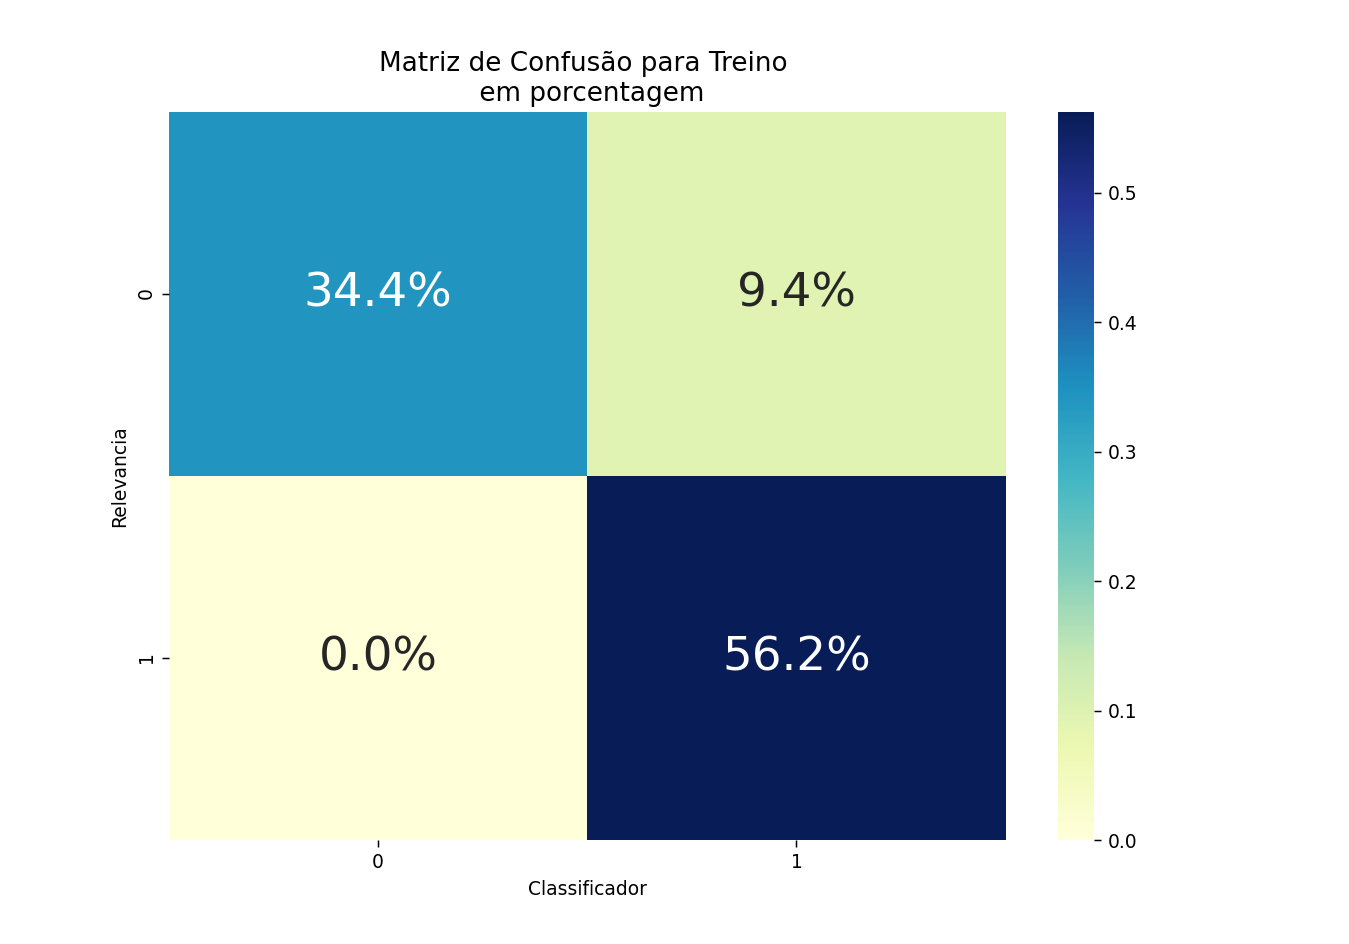

In [36]:
#Vendo a classificação efetiva

df_cm=pd.crosstab(train.Relevancia,train.Classificador,normalize=True)
plt.figure(figsize = (10,7))
plt.title('Matriz de Confusão para Treino \n em porcentagem',fontdict={'fontsize': 14})
sn.heatmap(df_cm, annot=True, annot_kws={"size": 25},fmt='.1%',cmap='YlGnBu')

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [37]:
#Aplicando no dataframe de teste
test['Classificador']=test.Clean.apply(Naive_Bayes)

In [38]:
tp=test.loc[(test['Classificador']==1)&(test['Relevancia']==1),:].shape[0]
tn=test.loc[(test['Classificador']==0)&(test['Relevancia']==0),:].shape[0]
print(f'A acurácia do modelo foi de: {100*(tp+tn)/test.shape[0]:.2f}%')

A acurácia do modelo foi de: 55.11%


<IPython.core.display.Javascript object>


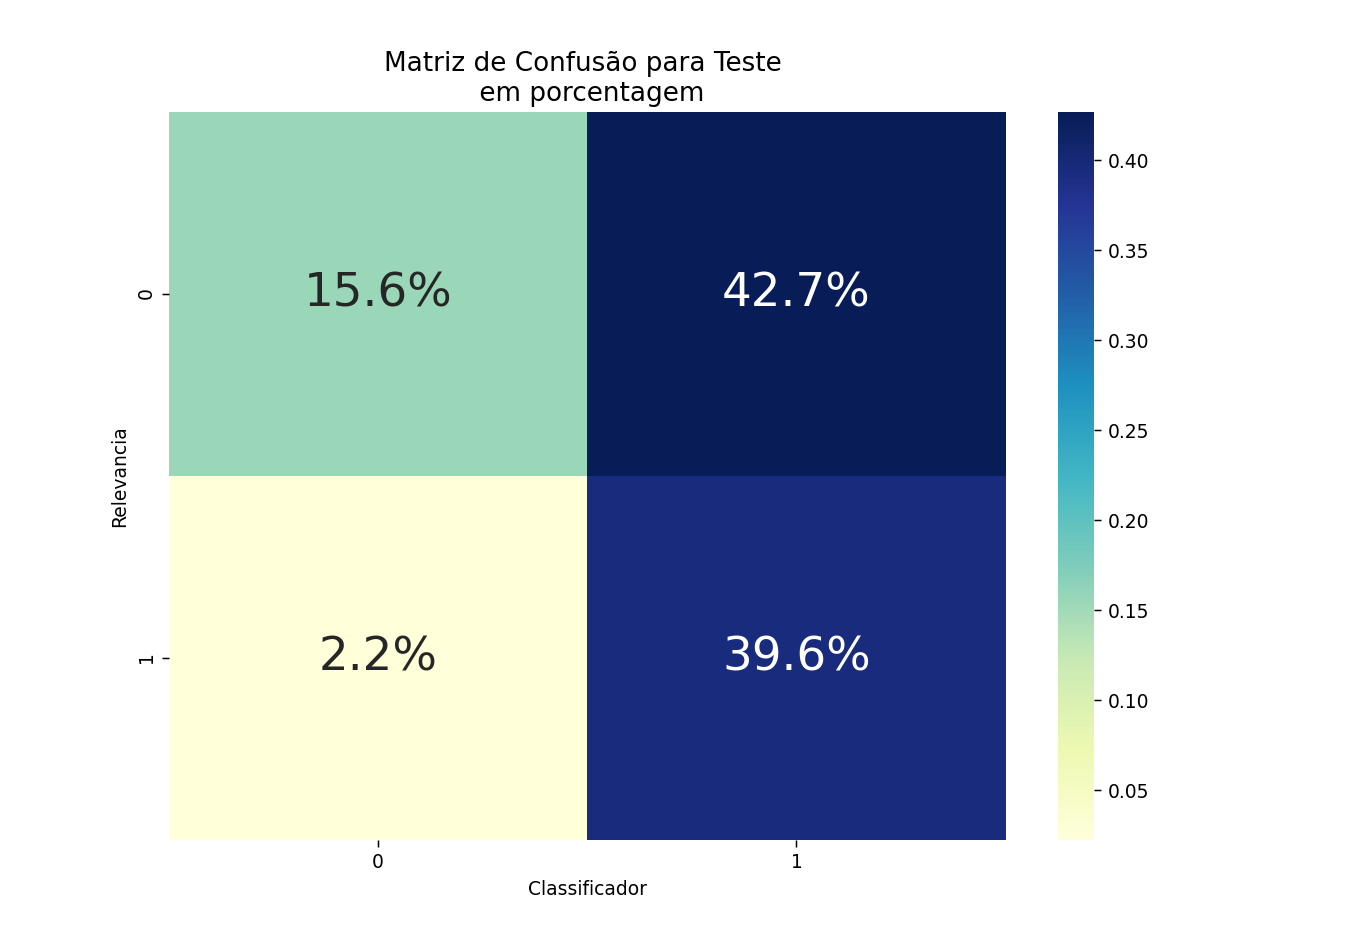

In [39]:
df_cm= pd.crosstab(test.Relevancia,test.Classificador,normalize=True)
plt.figure(figsize = (10,7))
plt.title('Matriz de Confusão para Teste \n em porcentagem',fontdict={'fontsize': 14})
sn.heatmap(df_cm, annot=True, annot_kws={"size": 25},fmt='.1%',cmap='YlGnBu')

___
### Concluindo

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

- Primeiramente iremos hospedar novamente a base de dados;
- Concatenar ambos os Dataframe de Teste e Treinamento em um só;
- Aplicar a função de limpeza no Dataframe resultante.

In [40]:
#Juntando os tweets em um unico DF
test_split = pd.read_excel(filename, sheet_name = 'Teste').drop('Relevancia',axis=1)
test_split = test_split.rename(columns={'New':'Relevancia'})
test_split = test_split.rename(columns={'Teste':'Total'})
test_split.head()

train_split = pd.read_excel(filename, sheet_name = 'Treinamento')
train_split = train_split.rename(columns={'Treinamento':'Total'})

#Concatenando as tabelas
data_set=pd.concat([train_split,test_split])

#Limpando os tweets
data_set['Clean']=data_set['Total'].apply(aplica)
data_set.head()

,Total,Relevancia,Clean
0,executivo da disney defendeu demissão de gina ...,0,"executivo,disney,defendeu,demissão,gina,carano..."
1,@daredvevil nao seriooo melhor dia 😭 volta the...,1,"daredvevil,nao,seriooo,melhor,dia,volta,precis..."
2,preciso terminar mandalorian logo,1,"preciso,terminar,logo,"
3,toda vez que eu vejo o baby yoda usando a forç...,0,"toda,vez,vejo,baby,yoda,usando,força,lembro,me..."
4,jon fraveau eu te amo obrigado por fazer the m...,1,"jon,fraveau,amo,obrigado,fazer,big,fan,here,"


##### Ajustando funções
- Iremos agora ajustar as funções de cálculo de probabilidade e classificação para que elas se adequem ao loop de repetição;
- Para tal, ajustaremos alguns parâmetros como a quantidade de palavras possíveis (vinda do treinamento que será splittado aleatoriamente a cada loop) e as listas de relevantes e irrelevantes de cada loop, para que mudem de acordo com o loop.
- Dessa forma as funções ficam aptas a essa adaptação com as mudanças abaixo:

In [41]:
#Guardando variáveis para substituição no loop

lista_r_split=[]
lista_i_split=[]
n_repetido_split={}

#Redefenindo funções adaptando-as ao contexto

def laplace_split(frequencia_absoluta,palavras_pertecentes_a_classe):
    '''
    Calcula a probabilidade de uma palavra no universo por suavização de Laplace
    '''
    return (frequencia_absoluta+1)/(len(palavras_pertecentes_a_classe)+len(n_repetido_split))

def P_tweet_r_split(tweet):
    '''
    Calcula a probabilidade do tweet ser relevante
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,lista_r_split)
        prob_palavra=laplace_split(fa,n_repetido_split)
        prob_tweet*=prob_palavra

    return prob_tweet

def P_tweet_i_split (tweet):
    '''
    Calcula a probabilidade do tweet ser irrelevante
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,lista_i_split)
        prob_palavra=laplace_split(fa,n_repetido_split)
        prob_tweet*=prob_palavra

    return prob_tweet

def Naive_Bayes_split (tweet):
    '''
    Julga por meio de probabilidade a relevância ou não de um tweet
    '''
    if(P_tweet_r_split(tweet)*Pr > P_tweet_i_split(tweet)*Pi):
        return 1
    else:
        return 0

##### Utilizaremos aqui o módulo sklearn que é próprio para análises de Machine Learning

Nele iremos importar a função 

>**train_test_split**

Essa função basicamente divide o conjunto de dados de Treinamento e teste em 4 variáveis, conhecidas como, respectivamente,
atributos de Treinamento, atributos de Teste, rótulos de Treino e rótulos de Teste, e em seus parâmetros internos podemos dividir a quantidade relativa de teste/treino que desejamos. Como fora solicitado em torno de 200/500, e temos 725 tweets nessa base de dados, iremos adotar a mesma proporção de 0.4, resultando em cerca de 290 tweets de teste para cada laço de repetição. Nota-se também que como não alteraremos o parâmetros <em>random_state</em> a função sempre irá dividir a base de dados diferentemente em cada repetição, atingindo o princípio esperado de Validação Cruzada deste item.

In [42]:
from sklearn.model_selection import train_test_split

lista_hist=[]

for i in range(0,100):
    
    X_train,X_test,y_train,y_test=train_test_split(data_set[['Clean','Relevancia']],data_set.Relevancia,
    test_size=0.40)
    
    train_relevantes=X_train[X_train['Relevancia']==1]
    train_irrelevantes=X_train[X_train['Relevancia']==0]
    
    palavras_r_split= frases_to_words(train_relevantes['Clean'])
    palavras_i_split= frases_to_words(train_irrelevantes['Clean'])
    
    list_i_split=palavras_i_split.tolist()
    list_r_split=palavras_r_split.tolist()
    
    total=pd.Series(list_i_split+list_r_split)
    
    Pr=len(palavras_r)/len(total)
    Pi=len(palavras_i)/len(total)

    n_repetido_split=set(list_i_split+list_r_split)

    X_test['Classificador']=X_test.Clean.apply(Naive_Bayes_split)
    verdadeiro_positivo=X_test.loc[(X_test['Classificador']==1)&(X_test['Relevancia']==1),:].shape[0]
    verdadeiro_negativo=X_test.loc[(X_test['Classificador']==0)&(X_test['Relevancia']==0),:].shape[0]
    score=(verdadeiro_positivo+verdadeiro_negativo)/X_test.shape[0]

    lista_hist.append(score*100)

<IPython.core.display.Javascript object>


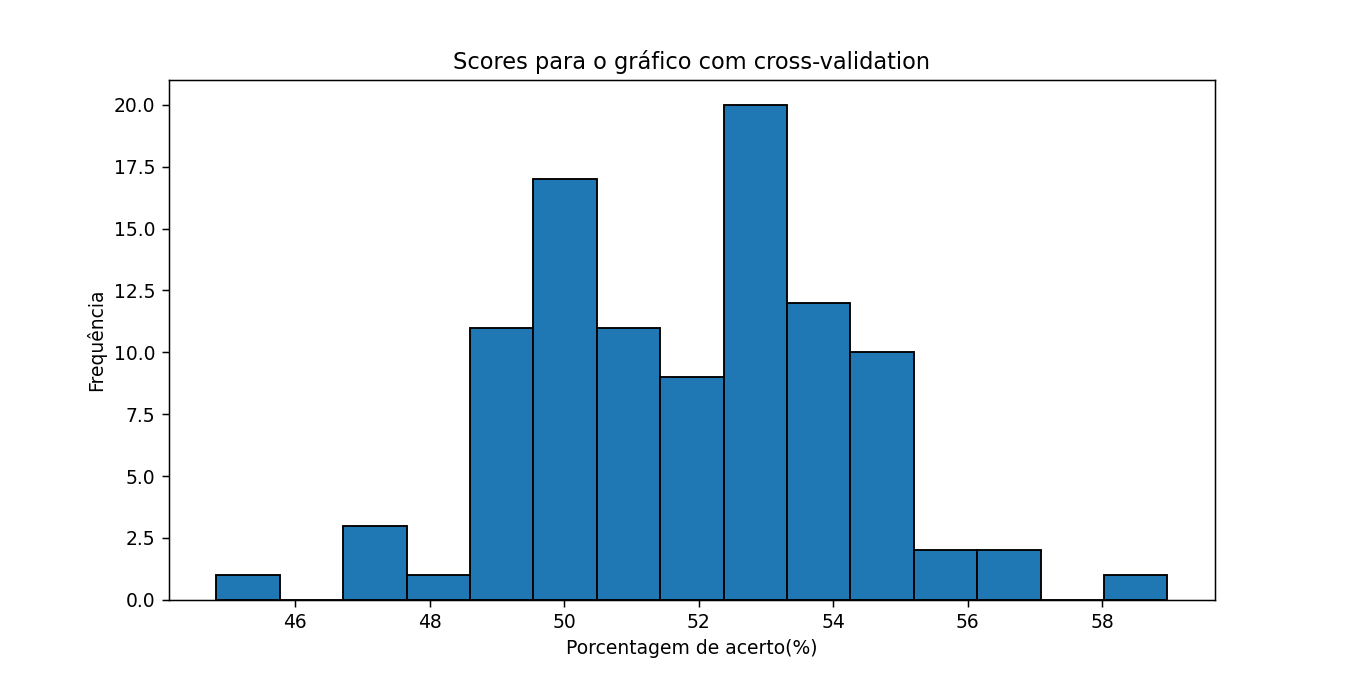

In [43]:
plt.figure(figsize=(10, 5))
plt.hist(lista_hist, bins=15, edgecolor='black', density=False)
plt.title('Scores para o gráfico com cross-validation')
plt.ylabel('Frequência')
plt.xlabel('Porcentagem de acerto(%)')
plt.show()

In [44]:
'''Podemos ver que realizando a chamada Cross-Validation, o processo de variar aleatoriamente 
conjunto de treino-teste, pode aumentar a possibilidade de scores melhores, dado que o melhor conjunto pode ser obtido
sempre com diferentes configurações. No caso vemos acima que basicamente quase todas as configurações acima tem melhores
scores que os obtidos pelo nosso modelo na conjuntura obtida.
Dessa forma podemos concluir que a utilização de validação cruzada é extramente útil para encontrar a melhor
conjuntura do conjunto de treino e de teste'''

'Podemos ver que realizando a chamada Cross-Validation, o processo de variar aleatoriamente \nconjunto de treino-teste, pode aumentar a possibilidade de scores melhores, dado que o melhor conjunto pode ser obtido\nsempre com diferentes configurações. No caso vemos acima que basicamente quase todas as configurações acima tem melhores\nscores que os obtidos pelo nosso modelo na conjuntura obtida.\nDessa forma podemos concluir que a utilização de validação cruzada é extramente útil para encontrar a melhor\nconjuntura do conjunto de treino e de teste'

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)


Definindo novas funções utilizadas para categorias intermediárias:

In [105]:
from math import ceil

def Naive_Bayes_new_categories(tweet):
    return P_tweet_r(tweet)*P_r -P_tweet_i(tweet)*P_i

def Separando_em_categorias(prob):
    
    '''
    Função recebe um valor de probabilidade. 
    Retorna rótulo Muito Irrelevante, Irrelevante, Neutro, Relevante ou Muito Relevante
    '''
    
    #Criando uma lista ordenada com os valores de probabilidade em ordem.
    prob_lista=test_new_cat.Prob.sort_values().tolist()
    
    #Contador que busca ponto de virada do sinal na lista ordenada de probabilidade.
    troca_sinal=0
    
    #Posição ultimo elemento da lista:
    pos_ultimo=len(prob_lista)
    
    for i, value in enumerate(prob_lista):
            
            if(value<0):           
                continue
            else:
                #Posição em que os valores mudam para positivo na lista ordenada de probabilidade
                troca_sinal=i                 
                break
    
    #Probabilidade recebida interpretada como neutra para valores próximos de 0
    if prob in prob_lista[troca_sinal-5:troca_sinal+10]:
         return 'Neutro'                       
    
    #Na classificação Relevante,Irrelevante buscamos metade das parcelas restantes do intervalo anterior e posterior 
    #ao neutro para a subdivisão: (Relevante, Muito relevante) e (Irrelevante, Muito irrelevante)
    
    else:    
        
        # Para a condição em que a probabilidade é negativa podemos dividi-la em 2 Subgrupos
        if prob < 0:
            
            #Primeira parcela de valores negativos (Valores mais negativos)
            if prob in prob_lista[0:ceil((troca_sinal-5)/2)]:
                return 'Muito Irrelevante'
            
            #Segunda parcela de valores negativos (Valores menos negativos)
            return 'Irrelevante'
        
        # Para a condição em que a probabilidade é positiva podemos dividi-la em 2 Subgrupos
        else:
            
            #Primeira parcela de valores positivos (Valores menos positivos)
            if prob in prob_lista[(troca_sinal+10):ceil((troca_sinal+10)+(pos_ultimo-(troca_sinal+10))/2)]:
                return 'Relevante'
            
            #Segunda parcela de valores positivos (Valores mais positivos)
            return 'Muito Relevante'
        
    
def classifica_intermediaria(tweet_prob):
    '''
    Função que cria novas categorias de classificação
    '''
    
    if (tweet_prob<test_new_cat.Prob.quantile(q=0.179)) and (tweet_prob>test_new_cat.Prob.quantile(q=0.169)):
        return 'Neutro'
    
    else:
        if tweet_prob<0:
            
            if tweet_prob>test_new_cat.Prob.quantile(q=0.178/2):
                return 'Irrelevante'
            return 'Muito Irrelevante'
        
        else:
            
            if tweet_prob > test_new_cat.Prob.quantile(q=0.59):
                return 'Muito Relevante'
            return 'Relevante'

In [109]:
# Copiando conjunto teste e aplicando nova classificação:

test_new_cat=test.copy()
test_new_cat['Prob']=test_new_cat['Clean'].apply(Naive_Bayes_new_categories)

In [110]:
#bin=[]
#for i in [0,0.25,0.5,0.55,0.75,1]:
    #bin.append(test_new_cat.Prob.quantile(q=i))
#x=pd.cut(test_new_cat.Prob,bins=bin,labels=['muito irrelevante','irrelevante','neutro','relevante','muito relevante'])
#x.value_counts(True)
#test_new_cat['Grau de Relevancia']=x

test_new_cat['Outro Rotulo']= test_new_cat.Prob.apply(classifica_intermediaria)
test_new_cat

,Teste,Relevancia,Clean,Classificador,Prob,Outro Rotulo
0,the mandalorian é uma série com dinheiro e tec...,1,"série,dinheiro,tecnicamente,boa,roteiro,padrão...",1,7.755182e-54,Relevante
1,agora comecei mandalorian confiando novamente ...,1,"agora,comecei,confiando,novamente,twitteiros,p...",1,2.178167e-35,Relevante
2,@fepazo1 @gabriel_ns1999 @joelmsimmons @jurand...,1,"fepazo1,gabriel_ns1999,joelmsimmons,jurandirfi...",1,3.034966e-101,Relevante
3,eu assisti 3 minutos de mandalorian e emocionei,1,"assisti,3,minutos,emocionei,",1,1.079606e-14,Muito Relevante
4,rt @anakinwar: já ta ...,0,"anakinwar,ta,mãe,chorando,final,dnv,garota,ht…,",1,1.578466e-28,Relevante
...,...,...,...,...,...,...
220,"tô com saudade de the mandalorian, acho que vo...",1,"tô,saudade,acho,vou,ver,tudo,novo,",1,6.605238e-21,Muito Relevante
221,meu deus pedro pascal é o mandalorian 😱😱😱😱😱😱😱,0,"deus,pedro,pascal,,rosto_gritando_de_medo,,,ro...",1,3.238820e-55,Relevante
222,@39marukin @ghostjacobs tem. assisti lá.\nagor...,1,"39marukin,ghostjacobs,assisti,lá,agora,finalme...",1,8.253499e-27,Relevante
223,@ip_mandalorian @tmarretamma ficou parecendo o...,0,"tmarretamma,ficou,parecendo,pequenino,filme,,r...",1,2.264795e-37,Relevante


In [112]:
test_new_cat['Novas Categorias']= test_new_cat.Prob.apply(quartil_probabilidade)
test_new_cat

,Teste,Relevancia,Clean,Classificador,Prob,Outro Rotulo,Novas_categorias,Novas Categorias
0,the mandalorian é uma série com dinheiro e tec...,1,"série,dinheiro,tecnicamente,boa,roteiro,padrão...",1,7.755182e-54,Relevante,Relevante,Relevante
1,agora comecei mandalorian confiando novamente ...,1,"agora,comecei,confiando,novamente,twitteiros,p...",1,2.178167e-35,Relevante,Relevante,Relevante
2,@fepazo1 @gabriel_ns1999 @joelmsimmons @jurand...,1,"fepazo1,gabriel_ns1999,joelmsimmons,jurandirfi...",1,3.034966e-101,Relevante,Neutro,Neutro
3,eu assisti 3 minutos de mandalorian e emocionei,1,"assisti,3,minutos,emocionei,",1,1.079606e-14,Muito Relevante,Muito Relevante,Muito Relevante
4,rt @anakinwar: já ta ...,0,"anakinwar,ta,mãe,chorando,final,dnv,garota,ht…,",1,1.578466e-28,Relevante,Relevante,Relevante
...,...,...,...,...,...,...,...,...
220,"tô com saudade de the mandalorian, acho que vo...",1,"tô,saudade,acho,vou,ver,tudo,novo,",1,6.605238e-21,Muito Relevante,Muito Relevante,Muito Relevante
221,meu deus pedro pascal é o mandalorian 😱😱😱😱😱😱😱,0,"deus,pedro,pascal,,rosto_gritando_de_medo,,,ro...",1,3.238820e-55,Relevante,Relevante,Relevante
222,@39marukin @ghostjacobs tem. assisti lá.\nagor...,1,"39marukin,ghostjacobs,assisti,lá,agora,finalme...",1,8.253499e-27,Relevante,Relevante,Relevante
223,@ip_mandalorian @tmarretamma ficou parecendo o...,0,"tmarretamma,ficou,parecendo,pequenino,filme,,r...",1,2.264795e-37,Relevante,Relevante,Relevante


In [107]:
#test_new_cat['Outro Rotulo'].value_counts()

Muito Relevante      92
Relevante            92
Muito Irrelevante    20
Irrelevante          18
Neutro                3
Name: Outro Rotulo, dtype: int64

In [113]:
test_new_cat['Novas Categorias'].value_counts()

Relevante            88
Muito Relevante      87
Muito Irrelevante    18
Irrelevante          17
Neutro               15
Name: Novas Categorias, dtype: int64

In [48]:
def dicio_r (palavra):
    
    nova=sn.Search(palavra).synonyms()   #Buscando sinônimos
    P_nova=0
    
    if nova != 404:
        
        for i in range(len(nova)):
        
            if (i != len(nova)-1):
                if (nova[i] in palavras_r) and (nova[i] not in lista_r):
                    P_nova=rel_relevantes[nova[i]]
                    return P_nova
                else:
                    continue

            else:
                return 1
    else:
        return 1
        

In [49]:
def dicio_i (palavra):
    
    nova=sn.Search(palavra).synonyms()   #Buscando sinônimos
    P_nova=0
    
    if nova != 404:
    
        for i in range(len(nova)):
            
            if (i != len(nova)-1):
            
                if (nova[i] in palavras_r) and (nova[i] not in lista_i):
                    P_nova=rel_relevantes[nova[i]]
                    return P_nova
                else:
                    continue
            
            else:
                return 1
    else:
        return 1

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**